URL : https://github.com/nxs5899/end-to-end-Machine-Learning-model-with-MLlib-in-pySpark/blob/master/MLlib_pySpark.ipynb

URL : https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5

In [1]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc.version

'3.1.1'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
       .master("local") \
       .appName("HARspark") \
       .config("spark.some.config.option", "some-value") \
       .getOrCreate()

In [3]:
new_df = spark.read.csv('test.csv', header=True, inferSchema=True)
new_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- rotationRate: double (nullable = true)
 |-- userAcceleration: double (nullable = true)
 |-- act: double (nullable = true)
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- trial: double (nullable = true)



In [4]:
act_lbl = ["Sat", "Stand-Up", "Downstairs", "Upstairs", "Walking", "Jogging"]

In [5]:
drop_col = ['_c0', 'id', 'trial']

new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df = new_df.withColumnRenamed('act', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,0.0,234657
1,1.0,224816
2,4.0,158645
3,3.0,58204
4,2.0,50246
5,5.0,104327


In [6]:
# ! pip install seaborn

830895


<AxesSubplot:xlabel='label', ylabel='count'>

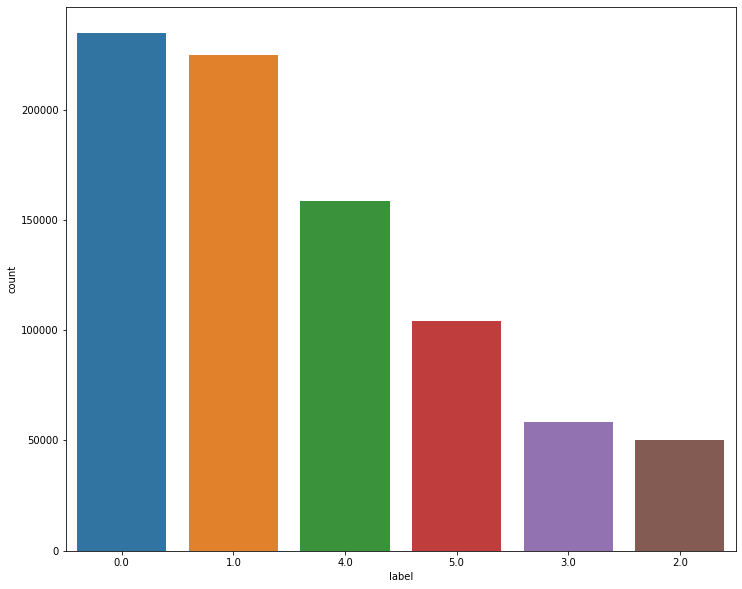

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_pd = new_df.toPandas()
print(len(df_pd))

plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

In [8]:
import pandas as pd

pd.DataFrame(new_df.take(10), columns= new_df.columns)

,rotationRate,userAcceleration,label,weight,height,age,gender
0,0.010253,0.006959,0.0,102.0,188.0,46.0,1.0
1,0.010920,0.010673,0.0,102.0,188.0,46.0,1.0
2,0.008377,0.007010,0.0,102.0,188.0,46.0,1.0
3,0.006555,0.014892,0.0,102.0,188.0,46.0,1.0
4,0.007724,0.013001,0.0,102.0,188.0,46.0,1.0
5,0.008544,0.008358,0.0,102.0,188.0,46.0,1.0
6,0.010706,0.007313,0.0,102.0,188.0,46.0,1.0
7,0.006017,0.011407,0.0,102.0,188.0,46.0,1.0
8,0.010136,0.008716,0.0,102.0,188.0,46.0,1.0
9,0.011316,0.010180,0.0,102.0,188.0,46.0,1.0


In [9]:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

0  categorical features
6  numerical features


In [10]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [11]:
missings = info_missing_table(df_pd)
missings

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [12]:
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [13]:
miss_counts = count_missings(new_df)
miss_counts

[]

In [14]:
# # adding the new column weights and fill it with ratios
# from pyspark.sql.functions import when

# ratio = 0.91
# def weight_balance(labels):
#     return when(labels == 1, ratio).otherwise(1*(1-ratio))

# new_df = new_df.withColumn('weights', weight_balance(col('label')))

In [15]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,rotationRate,userAcceleration,label,weight,height,age,gender
0,0.010253,0.006959,0.0,102.0,188.0,46.0,1.0
1,0.010920,0.010673,0.0,102.0,188.0,46.0,1.0
2,0.008377,0.007010,0.0,102.0,188.0,46.0,1.0
3,0.006555,0.014892,0.0,102.0,188.0,46.0,1.0
4,0.007724,0.013001,0.0,102.0,188.0,46.0,1.0
5,0.008544,0.008358,0.0,102.0,188.0,46.0,1.0
6,0.010706,0.007313,0.0,102.0,188.0,46.0,1.0
7,0.006017,0.011407,0.0,102.0,188.0,46.0,1.0
8,0.010136,0.008716,0.0,102.0,188.0,46.0,1.0
9,0.011316,0.010180,0.0,102.0,188.0,46.0,1.0


In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [17]:
from pyspark.ml import Pipeline

cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)

In [18]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,rotationRate,userAcceleration,label,weight,height,age,gender
0,"[0.006959199379238966, 0.0, 102.0, 188.0, 46.0...",0.010253,0.006959,0.0,102.0,188.0,46.0,1.0
1,"[0.010672920359489243, 0.0, 102.0, 188.0, 46.0...",0.010920,0.010673,0.0,102.0,188.0,46.0,1.0
2,"[0.0070096587648757905, 0.0, 102.0, 188.0, 46....",0.008377,0.007010,0.0,102.0,188.0,46.0,1.0
3,"[0.014892331247994722, 0.0, 102.0, 188.0, 46.0...",0.006555,0.014892,0.0,102.0,188.0,46.0,1.0
4,"[0.013001225519157802, 0.0, 102.0, 188.0, 46.0...",0.007724,0.013001,0.0,102.0,188.0,46.0,1.0


In [19]:
# split the data into trainign and testin sets

train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

664598
166297


## LogisticRegression

In [20]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

In [21]:
print("Coefficients: \n" + str(LR_model.coefficientMatrix))
print("Intercept: " + str(LR_model.interceptVector))

trainingSummary = LR_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

Coefficients: 
DenseMatrix([[-1.20449697e+01, -7.69755586e+00,  1.12432055e-04,
               7.11144298e-02,  5.25037207e-02, -2.49300772e-01],
             [-1.08811733e+01, -3.46929282e+00,  4.07349934e-03,
               5.92307740e-02,  3.66677397e-02,  7.47948316e-04],
             [ 1.42031302e+00, -6.76232246e-02, -1.43905838e-03,
               3.68076343e-02, -1.28106499e-02, -1.98153204e-01],
             [ 6.75431755e-01,  9.76493131e-01,  2.99541370e-03,
               2.20187211e-02, -1.25614344e-02, -1.69303965e-01],
             [ 6.32494951e+00,  5.03402566e+00,  6.90991818e-04,
              -7.05057046e-02, -5.31035570e-02,  8.98289766e-01],
             [ 1.45054487e+01,  5.22395311e+00, -6.43327854e-03,
              -1.18665855e-01, -1.06958191e-02, -2.82279773e-01]])
Intercept: [0.7163840679436299,0.6911085352594769,-0.8182303695297151,-0.6782234352376645,0.24651622944435425,-0.1575550278800814]
objectiveHistory:
1.6436981706571454
1.4378105959847745
1.124376186

In [22]:
#for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

False positive rate by label:
label 0: 0.0
label 1: 0.0002680279738734578
label 2: 0.00026746489723422076
label 3: 0.001864225480661088
label 4: 0.057955382315091016
label 5: 0.046269365669972154
True positive rate by label:
label 0: 0.9999254295788902
label 1: 0.9991424148261998
label 2: 0.918342989283139
label 3: 0.805603790168714
label 4: 0.8264892728218548
label 5: 0.7011873982572058
Precision by label:
label 0: 1.0
label 1: 0.9992759676970203
label 2: 0.9954986522911051
label 3: 0.9702563837752705
label 4: 0.770893371757925
label 5: 0.6854267828935822
Recall by label:
label 0: 0.9999254295788902
label 1: 0.9991424148261998
label 2: 0.918342989283139
label 3: 0.805603790168714
label 4: 0.8264892728218548
label 5: 0.7011873982572058
F-measure by label:
label 0: 0.9999627133992063
label 1: 0.9992091867989886
label 2: 0.9553655729011731
label 3: 0.8802970320223008
label 4: 0.797723832056539
label 5: 0.6932175209604222


In [23]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.910475204559749
FPR: 0.017099670896580835
TPR: 0.9104752045597488
F-measure: 0.9114934459429685
Precision: 0.9141633322021094
Recall: 0.9104752045597488


In [47]:
predictions = LR_model.transform(test)
predictions.select("prediction").show(1)

+----------+
|prediction|
+----------+
|       1.0|
+----------+
only showing top 1 row



In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9109739574193125

### Test

In [59]:
inputCols = ["rotationRate", "userAcceleration","weight", "height", "age", "gender"]

outputCol = "features"

In [63]:
# df = spark.createDataFrame([(0.010253, 0.006959, 102.0, 188.0, 46.0, 1.0)], inputCols)
df = spark.createDataFrame([(3.8651705114155055,1.6289638410434408,70.0,180.0,35.0,1.0)], inputCols)

In [64]:
df_va = VectorAssembler(inputCols = inputCols, outputCol = outputCol)

df = df_va.transform(df)

In [65]:
prediction = LR_model.transform(df)
prediction.select("prediction").show()

+----------+
|prediction|
+----------+
|       5.0|
+----------+



# Gradio UI

In [ ]:
! pip install gradio